# 0. Setup

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections
import pandas as pd
import numpy as np
import math
import pickle
#%matplotlib notebook
%matplotlib inline
labelsize=24
matplotlib.rc('xtick', labelsize=labelsize) 
matplotlib.rc('ytick', labelsize=labelsize)

In [16]:
# Import blocksci
import blocksci

# Create a Blockhain object
parser_data_directory = "/home/bitcoin/BlockSci/parsed-data-bitcoin"
chain = blocksci.Blockchain(parser_data_directory)

pick_folder = "pickle_files/predictions/"

In [37]:
def avg_from_dict(d):
    avg_pksize = 0
    counter = 0
    for k,v in d.items():
        avg_pksize += k*v
        counter += v
    
    return avg_pksize / counter if counter != 0 else np.nan


def df_resample_mean(df, granul=10):
    grouped_df = df.groupby(np.arange(len(df))//granul).mean()
    return grouped_df


def avg_per_block(pubkey_sizes):
    height_avgpubkeysize = []
    for height, sizes in pubkey_sizes.items():
        height_avgpubkeysize.append((height, avg_from_dict(sizes)))
    return height_avgpubkeysize


def age_analysis(whens):
    parsed_ok = sum([sum(v.values()) for v in whens.values()])
    agg = {}
    for values in whens.values():
        for k, v in values.items():
            if k in agg.keys():
                agg[k] += v
            else:
                agg[k] = v
    assert(sum(agg.values())==parsed_ok)
    print("The average age is {}".format(avg_from_dict(agg)))
    #print("I have found values {}".format(agg.keys()))

# 3. Will an output be spent?

In [17]:
#(spent, whens) = pickle.load(open("spent_outputs.pickle", "rb"))

# Spent is a dictionary of dictionaries
# Outer dictionary: key is block height, value is inner dictionary
# Inner dict: Key is True / False, values are number of outputs of that block that are spent / not spent
spent = pickle.load(open(pick_folder+"spent_only.pickle", "rb"))

For each block, show what fraction of outputs of that block have been spent

In [18]:
fraction_spent = [(k, v[True]/(v[True]+v[False])) for k,v in spent.items()]

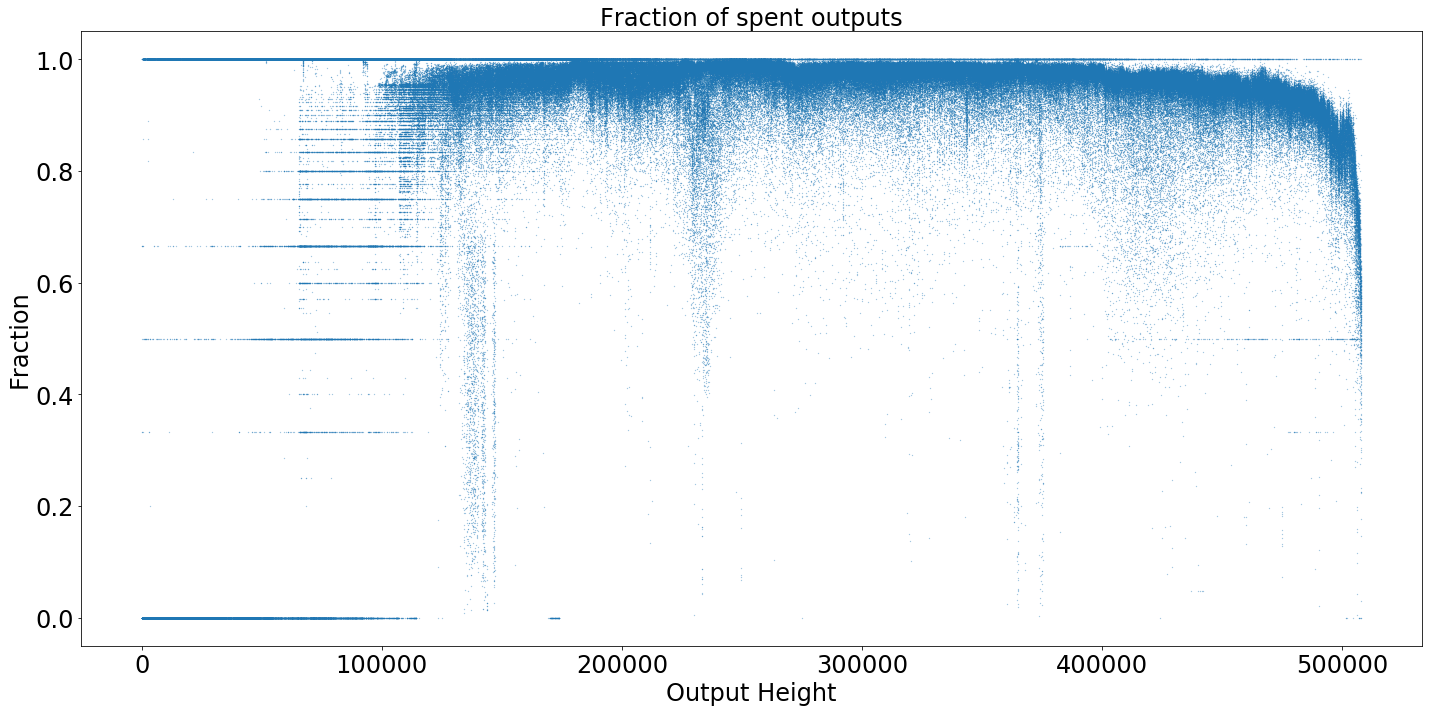

In [19]:
df_fraction_spent = pd.DataFrame(fraction_spent, columns=["Output Height", "Fraction of outs spent"])
df_fraction_spent.index = df_fraction_spent["Output Height"]
del df_fraction_spent["Output Height"]

plt.figure(figsize=(20,10))
plt.scatter(df_fraction_spent.index, df_fraction_spent["Fraction of outs spent"], s=0.05, alpha=0.75)
plt.title("Fraction of spent outputs", {'color': 'k', 'fontsize': 24})
plt.xlabel("Output Height", {'color': 'k', 'fontsize': 24})
plt.ylabel("Fraction", {'color': 'k', 'fontsize': 24})
plt.tight_layout()

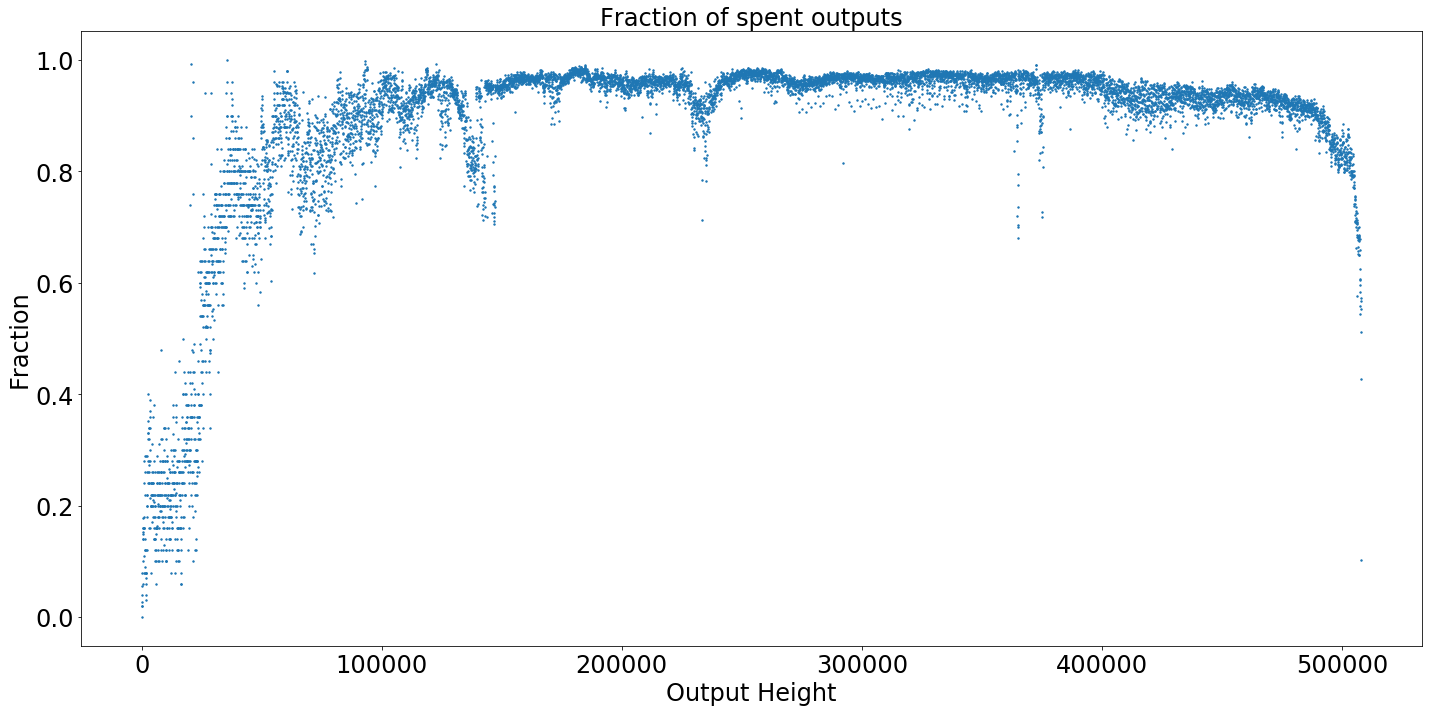

In [22]:
df_fraction_spent = pd.DataFrame(fraction_spent, columns=["Output Height", "Fraction of outs spent"])
df_fraction_spent_res = df_resample_mean(df_fraction_spent, 50)
df_fraction_spent_res.index = df_fraction_spent_res["Output Height"]
del df_fraction_spent["Output Height"]

plt.figure(figsize=(20,10))
plt.scatter(df_fraction_spent_res.index, df_fraction_spent_res["Fraction of outs spent"], s=2, alpha=1)
plt.title("Fraction of spent outputs", {'color': 'k', 'fontsize': 24})
plt.xlabel("Output Height", {'color': 'k', 'fontsize': 24})
plt.ylabel("Fraction", {'color': 'k', 'fontsize': 24})
plt.tight_layout()

At what height are the current UTXOs?

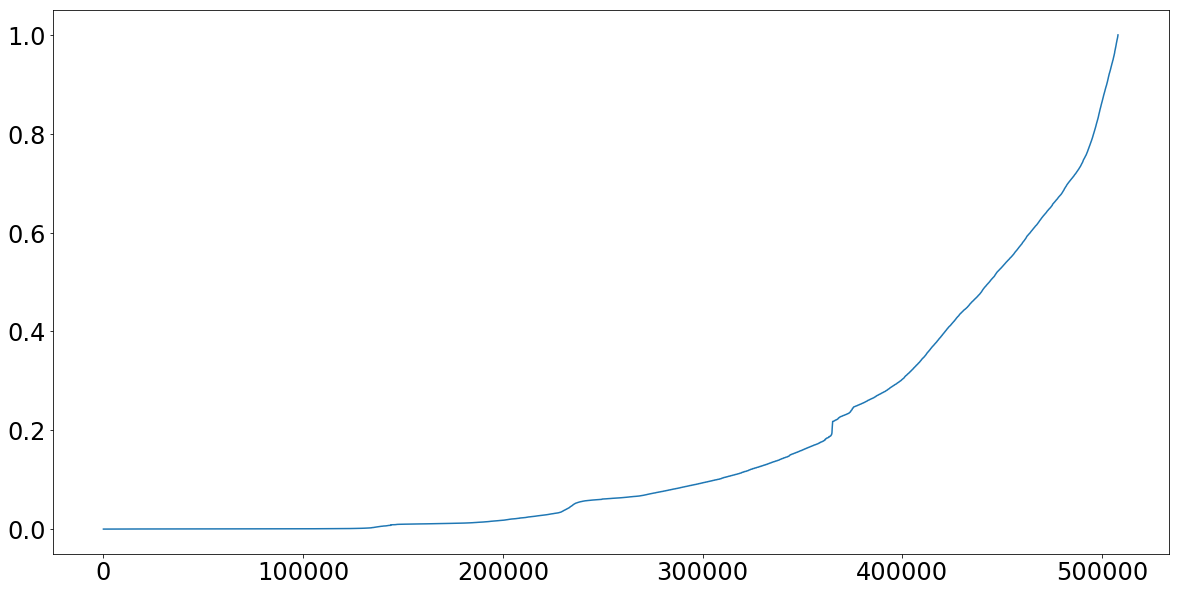

In [23]:
total_utxos = sum([v[False] for k,v in spent.items()])
utxos = [(k, v[False]/total_utxos) for k,v in spent.items()]

df_utxo = pd.DataFrame(utxos, columns=["Output Height", "UTXO count"])
df_utxo.index = df_utxo["Output Height"]
del df_utxo["Output Height"]
ser_cdf = df_utxo.cumsum()

plt.figure(figsize=(20,10))
plt.plot(ser_cdf, drawstyle='steps')

In [24]:
def sh_entropy(probs):
    return -sum(p*math.log(p,2) for p in probs if p != 0)
    

def cond_sh_entropy(spent):
    spent_true = sum([v[True] for k, v in spent.items()])
    spent_false = sum([v[False] for k, v in spent.items()])
    total_outs = spent_true + spent_false

    s = 0
    for k,v in spent.items():
        px = (v[True]+v[False])/total_outs
        cond_ent = sh_entropy([v[True]/(v[True]+v[False]), v[False]/(v[True]+v[False])])
        s += px*cond_ent
    
    return s


def quantizer(data, num_bins, q_type="linear"):
    mi = min(data.keys())
    ma = max(data.keys())
    intervals = np.linspace(mi, ma, num=num_bins+1)
    
    agg_data = {i: {True:0, False:0} for i in range(len(intervals)-1)}

    #print("{} {}".format(mi, ma))
    #print(agg_data)

    # We optimize for a sorted dictionary, although we can no enusre that it will be sorted, so
    # if we get to the end of the intervals, we start againat the beginning.
    # Not very nice, but it turns out it is much faster than iterating throguh intervals from the start each time
    i = 0
    for k, v in data.items():
        while not ((k > intervals[i] and k <= intervals[i+1]) or (i == 0 and k >= intervals[0] and k <= intervals[1])):
            i = (i + 1)%len(intervals)
            
        agg_data[i][True] += v[True]
        agg_data[i][False] += v[False]

    assert sum([v[True] for k, v in data.items()]) == sum([v[True] for k, v in agg_data.items()]), "Error: sum of Trues does not match"
    assert sum([v[False] for k, v in data.items()]) == sum([v[False] for k, v in agg_data.items()]), "Error: sum of Falses does not match"
        
    return agg_data, intervals

In [25]:
a = {0 : {True:10, False:0}, 1: {True:0, False:10}, 10:{True:5, False:5}}
agg, inte = quantizer(a, 2, q_type="linear")
print(agg)
print(inte)

{0: {False: 10, True: 10}, 1: {False: 5, True: 5}}
[ 0.  5. 10.]


In [26]:
spent_true = sum([v[True] for k, v in spent.items()])
spent_false = sum([v[False] for k, v in spent.items()])
total_outs = spent_true + spent_false

print("There are {} outputs: {} spent ({}%) and {} unspent ({}%)".format(total_outs, spent_true, spent_true/total_outs, spent_false, spent_false/total_outs))
probs = [spent_true/total_outs, spent_false/total_outs]
sh_entropy(probs)

There are 809995337 outputs: 745371789 spent (0.9202173826835253%) and 64623548 unspent (0.07978261731647475%)


0.40141276532053527

In [27]:
cond_sh_entropy(spent)

0.3457796467367693

In [29]:
(spent_height, spent_txsize, spent_scripttype, spent_amount, spent_iscoinbase) = pickle.load(open(pick_folder+"spent_condit.pickle", "rb"))

In [30]:
print("H( P(is_spent | height) ) = {}".format(cond_sh_entropy(spent_height)))
print("H( P(is_spent | txsize) ) = {}".format(cond_sh_entropy(spent_txsize)))
print("H( P(is_spent | scripttype) ) = {}".format(cond_sh_entropy(spent_scripttype)))
#print("H( P(is_spent | amount) ) = {}".format(cond_sh_entropy(spent_amount)))
print("H( P(is_spent | is_coinbase) ) = {}".format(cond_sh_entropy(spent_iscoinbase)))

H( P(is_spent | height) ) = 0.3457796467367693
H( P(is_spent | txsize) ) = 0.3478031286347375
H( P(is_spent | scripttype) ) = 0.3784645808215693
H( P(is_spent | is_coinbase) ) = 0.40138930597282924


In [31]:
print("There are {} different height values".format(len(spent_height.keys())))
print("There are {} different txsize values".format(len(spent_txsize.keys())))
print("There are {} different scriptype values".format(len(spent_scripttype.keys())))
print("There are {} different amount values".format(len(spent_amount.keys())))
print("There are {} different iscoinbase values".format(len(spent_iscoinbase.keys())))

There are 507952 different height values
There are 86035 different txsize values
There are 8 different scriptype values
There are 131208451 different amount values
There are 2 different iscoinbase values


In [32]:
spent_1000, spent_1000_interv = quantizer(spent, num_bins=1000, q_type="linear")
cond_sh_entropy(spent_1000)

0.3813976893704977

In [33]:
spent_10000, spent_10000_interv = quantizer(spent, num_bins=10000, q_type="linear")
cond_sh_entropy(spent_10000)

0.37498922540335594

In [34]:
spent_100000, spent_100000_interv = quantizer(spent, num_bins=100000, q_type="linear")
cond_sh_entropy(spent_100000)

0.3623778286405617

# 3. When will an output be spent?

In [9]:
# Spent is a dictionary of dictionaries
# Outer dictionary: key is block height, value is inner dictionary
# Inner dict: Key is age, values are number of outputs of that block with that age
# age = number of blocks the output remains unspent
whens = pickle.load(open("pickle_files/predictions/when_only.pickle", "rb"))

In [12]:
height_avg_out_age = avg_per_block(whens)

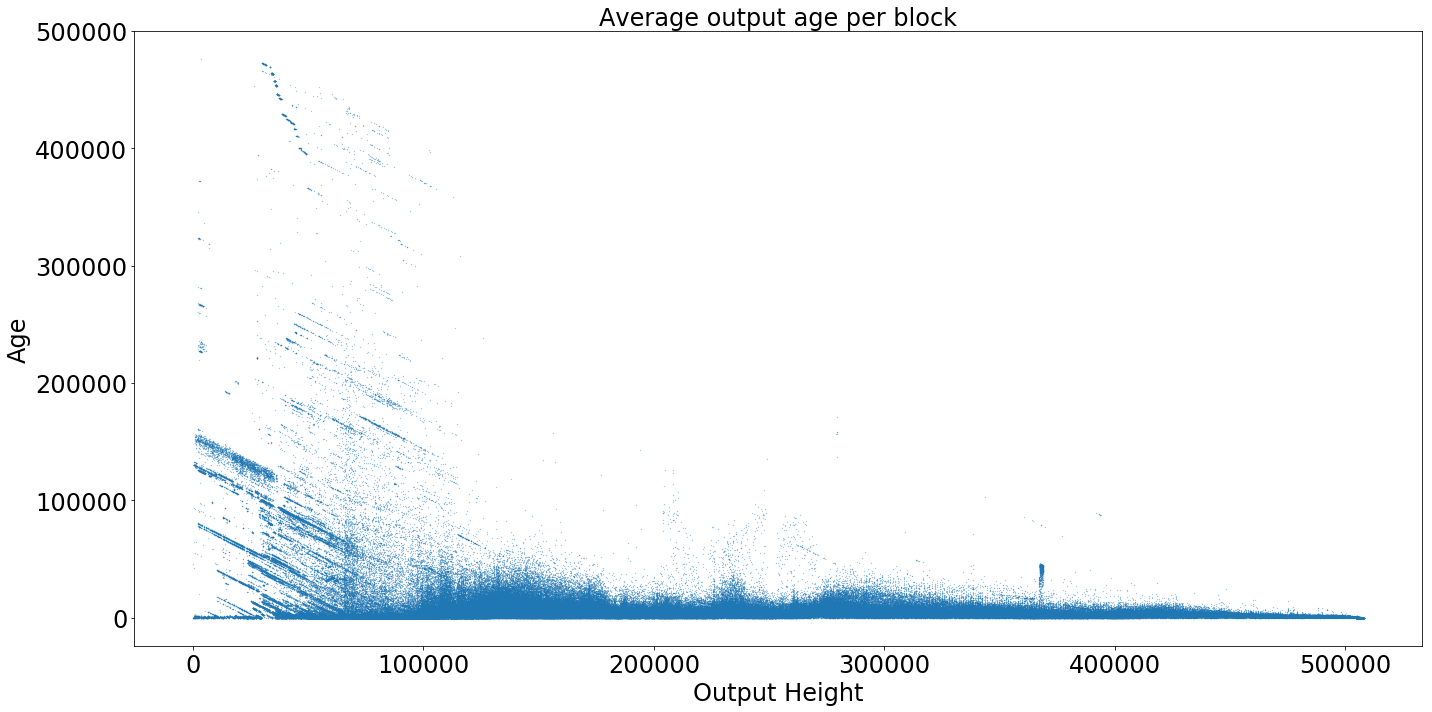

In [13]:
df_ages = pd.DataFrame(height_avg_out_age, columns=["Output Height", "Avg. age"])
df_ages.index = df_ages["Output Height"]
del df_ages["Output Height"]

plt.figure(figsize=(20,10))
plt.scatter(df_ages.index, df_ages["Avg. age"], s=0.05, alpha=0.75)
plt.title("Average output age per block", {'color': 'k', 'fontsize': 24})
plt.xlabel("Output Height", {'color': 'k', 'fontsize': 24})
plt.ylabel("Age", {'color': 'k', 'fontsize': 24})
plt.tight_layout()

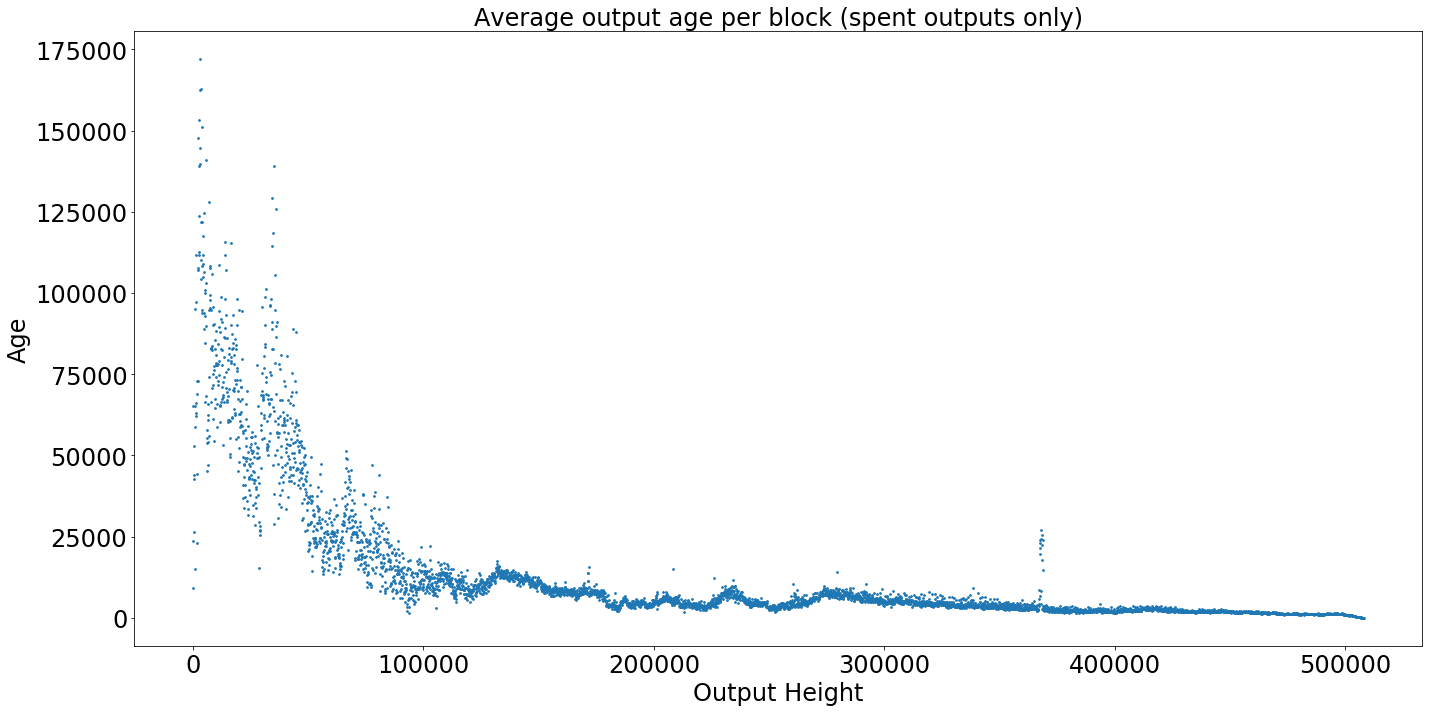

In [35]:
df_ages = pd.DataFrame(height_avg_out_age, columns=["Output Height", "Avg. age"])
df_ages_res = df_resample_mean(df_ages, 100)
df_ages_res.index = df_ages_res["Output Height"]
del df_ages_res["Output Height"]

plt.figure(figsize=(20,10))
plt.scatter(df_ages_res.index, df_ages_res["Avg. age"], s=3, alpha=1)
plt.title("Average output age per block (spent outputs only)", {'color': 'k', 'fontsize': 24})
plt.xlabel("Output Height", {'color': 'k', 'fontsize': 24})
plt.ylabel("Age", {'color': 'k', 'fontsize': 24})
plt.tight_layout()

In [38]:
age_analysis(whens)

The average age is 3558.238303168461
